# Mappr

> Scale up evaluation report mapping against evaluation frameworks using agentic workflows


::: {.callout-warning}
This notebook is a work in progress.
:::

Manually mapping evaluation reports against IOM's [Strategic Results Framework (SRF)](https://srf.iom.int) is time-consuming and resource-intensive with ~150 outputs to analyze. Additionally, the mapping process needs transparent and human-readable traces of LLM decision flows that both reflect natural reasoning patterns and allow human evaluators to audit the mapping logic.

A three-stage async pipeline leveraging [Global Compact for Migration (GCM) UN General Assembly Resolution](https://www.un.org/en/development/desa/population/migration/generalassembly/docs/globalcompact/A_RES_73_195.pdf) objectives as SRF Outputs pruning mechanism:



**Stage 1**: SRF Enablers & Cross-cutting Analysis

- **Async parallel analysis** of Enablers (7 categories) and Cross-cutting Priorities (4 categories) using shared semaphore for rate limiting
- **Purpose**: Identify if report is primarily meta-evaluation/transversal in nature
- **Fast processing**: ~11 items total with concurrent execution, provides context for subsequent stages

**Stage 2**: Informed GCM Analysis

- **Rate-limited parallel processing** of GCM Objectives (23 items) informed by Stage 1 results
- **Condensed representations**: UN General Assembly Resolution formulation simplified for retrieval efficiency
- **Concurrent theme analysis** with API quota management

**Stage 3**: Targeted SRF Analysis

- **SRF Filtering**: Use GCM results + `gcm_srf_lut` lookup table to prune ~150 SRF outputs to ~20-50 relevant ones
- **Deep parallel analysis**: Full hierarchy context (objective → outcome → output → indicators)
- **Async batch processing**: Final targeted analysis of pruned SRF outputs with retry logic and error handling

::: {.column-body}
![Three-stage Pipeline Overview](img/three-stage-pipeline-overview.png){fig-align="center" width="800px"}
:::

In [ ]:
#| default_exp mappr

In [ ]:
#| exports
from pathlib import Path
from functools import reduce
from toolslm.md_hier import *
from rich import print
import json
from fastcore.all import *
from enum import Enum
import logging
import uuid
from datetime import datetime
from typing import List, Callable
import dspy
import time
from collections import defaultdict
import copy
from copy import deepcopy
from dataclasses import dataclass
from typing import List
from pydantic import BaseModel, Field
import asyncio
from asyncio import Semaphore, gather, sleep

from evaluatr.frameworks import (EvalData, 
                                 IOMEvalData, 
                                 FrameworkInfo, 
                                 Framework,
                                 FrameworkCat,
                                 find_srf_output_by_id)

from fastlite import Database
from apswutils.db import NotFoundError

from lisette import mk_msg, AsyncChat
from lisette.core import acompletion

In [ ]:
#| exports
from dotenv import load_dotenv
import os

load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

In [ ]:
#| exports
cfg = AttrDict({
    'lm': 'gemini/gemini-2.0-flash',
    'api_key': GEMINI_API_KEY,
    'max_tokens': 8192,
    'track_usage': False,
    'call_delay': 0.1, # in seconds
    'semaphore': 2,
    'dirs': AttrDict({
        'data': '.evaluatr',
        'trace': 'traces'
    }),
    'verbosity': 1,
    'cache': AttrDict({
        'db_name':  'pipeline_cache.db'
    }),
})

In [ ]:
#| exports
traces_dir = Path.home() / cfg.dirs.data / cfg.dirs.trace
traces_dir.mkdir(parents=True, exist_ok=True)

## DB cache setup

In [ ]:
#| exports
db_path = traces_dir / cfg.cache.db_name
db = Database(db_path)

In [ ]:
#| exports
@dataclass
class SectionsCache:
    report_id: str
    sections_selected: str  # JSON list
    reasoning: str
    timestamp: str = None

In [ ]:
#| exports
@dataclass
class ThemeTaggingCache:
    report_id: str
    stage: str
    framework: str
    framework_category: str
    framework_theme_id: str
    is_core: bool
    reasoning: str
    confidence: str
    timestamp: str = None

In [ ]:
#| exports
sections_cache = db.create(SectionsCache, pk='report_id', ignore=True)
theme_cache = db.create(
    ThemeTaggingCache, 
    pk=['report_id', 'stage', 'framework', 'framework_category', 'framework_theme_id'],
    ignore=True
)

## Report loading

In [ ]:
#| exports
def load_report(
    doc_path:str # Path to the evaluation report
    ):
    "Read evaluation report from enriched markdown pages"
    doc = Path(doc_path)
    pages = doc.ls(file_exts=".md").sorted(key=lambda p: int(p.stem.split('_')[1]))
    report = '\n\n---\n\n'.join(page.read_text() for page in pages)
    return report

In [ ]:
#| eval: false
# "abridged_evaluation_report_final_olta_ndoja_pdf/enriched" (shorter version for testing)
doc_path = "../_data/md_library/49d2fba781b6a7c0d94577479636ee6f/final_evaluation_report_final_olta_ndoja_pdf/enriched"
doc_path = "../_data/md_library/evaluation-of-iom-accountability-tmp/aap_evaluation_report_final_pdf/enriched"
doc_path = "../_data/md_library/evaluation-of-iom-accountability-tmp/final_evaluation_report_final_pdf/enriched"
doc_path = "../_data/md_library/22cac1c000836253adc445993e101560/final_report_evaluation_of_mhpss_in_iom_8_2024_pdf/enriched"

report = load_report(doc_path)
print(report[:1000])

!(img-0.jpeg)

# Evaluation of Mental Health and Psychosocial Support in IOM .... page 1

IOM CENTRAL EVALUATION

August 2024

---

# ACKNOWLEDGEMENTS .... page 2

The evaluation was undertaken by external consultants of Peace in Practice consultancy, on behalf of the Central 
Evaluation Division (CED). The team was composed of Dr. Leslie Snider (lead) and Dr. Carolina Herbert.

The consultants would like to extend their sincere thanks to all those who gave their time and input to the 
evaluation, including the representatives of Member States, UN agencies, international NGOs, academia and other 
external stakeholders, and IOM staff and managers at all levels of the Organization. Special appreciation is 
extended to IOM MHPSS staff and managers for their thoughtful reflections, and to the contributors for the case 
studies from IOM MHPSS country and regional offices in Ukraine, Poland, West and Central Africa, and Colombia. 
Finally, the consultants are grateful for the unwaverin

## Hierarchical report navigation

Thanks to `toolslm.md_hier` and a clean markdown structure of a `report` markdown, we can create a nested dictionary of section, subsection, ... as follows:

In [ ]:
#| eval: false
hdgs = create_heading_dict(report)

In [ ]:
#| exports
def find_section_path(
    hdgs: dict, # The nested dictionary structure
    target_section: str # The section name to find
) -> list: # The nested key path for the given section name
    "Find the nested key path for a given section name."
    def search_recursive(current_dict, path=[]):
        for key, value in current_dict.items():
            current_path = path + [key]
            if key == target_section:
                return current_path
            if isinstance(value, dict):
                result = search_recursive(value, current_path)
                if result:
                    return result
        return None
    
    return search_recursive(hdgs)

Then we can retrieve the subsection path (list of nested headings to reach this specific section) in this nested `hdgs` dict :

In [ ]:
#| eval: false
path = find_section_path(hdgs, "Executive summary .... page 10"); path

Then retrieve the specific subsection content:

In [ ]:
#| exports
def get_content_tool(
    hdgs: dict, # The nested dictionary structure
    keys_list: list, # The list of keys to navigate through
    ) -> str: # The content of the section
    "Navigate through nested levels using the exact key strings."
    return reduce(lambda current, key: current[key], keys_list, hdgs).text

In [ ]:
#| eval: false
content = get_content_tool(hdgs, path)
print(content[:500])

TypeError: reduce() arg 2 must support iteration

In [ ]:
#| exports
def flatten_sections(
    hdgs: dict, # The nested dictionary-like structure of the report also allowing to pull content from 
    path: list = [] # The current path in the nested structure
    ) -> list: # The flat list of (key, full_path) tuples
    "Extract flat list of (key, full_path) tuples from nested hdgs"
    sections = []
    for key, value in hdgs.items():
        current_path = path + [key]
        sections.append((key, current_path))
        if isinstance(value, dict):
            sections.extend(flatten_sections(value, current_path))
    return sections

In [ ]:
#| eval: false
print(flatten_sections(hdgs)[:10])

[
    (
        'Evaluation of IOM Accountability to Affected Populations',
        ['Evaluation of IOM Accountability to Affected Populations']
    ),
    (
        'IOM CENTRAL EVALUATION',
        ['Evaluation of IOM Accountability to Affected Populations', 'IOM CENTRAL EVALUATION']
    ),
    (
        'December 2024',
        ['Evaluation of IOM Accountability to Affected Populations', 'IOM CENTRAL EVALUATION', 'December 2024']
    ),
    ('ACKNOWLEDGEMENTS', ['ACKNOWLEDGEMENTS']),
    ('TABLE OF CONTENTS', ['TABLE OF CONTENTS']),
    ('LIST OF FIGURES AND TABLES', ['LIST OF FIGURES AND TABLES']),
    ('LIST OF ACRONYMS', ['LIST OF ACRONYMS']),
    ('EXECUTIVE SUMMARY', ['EXECUTIVE SUMMARY']),
    ('1. BACKGROUND', ['1. BACKGROUND']),
    ('Evaluation Context', ['1. BACKGROUND', 'Evaluation Context'])
]

In [ ]:
#| exports
def format_toc_for_llm(hdgs: dict) -> str:
    """Format ToC as readable text with page numbers"""
    sections = flatten_sections(hdgs)
    lines = [f"- {key}" for key, path in sections]
    return '\n'.join(lines)

In [ ]:
#| eval: false
print(format_toc_for_llm(hdgs)[:500])

- Evaluation of IOM Accountability to Affected Populations
- IOM CENTRAL EVALUATION
- December 2024
- ACKNOWLEDGEMENTS
- TABLE OF CONTENTS
- LIST OF FIGURES AND TABLES
- LIST OF ACRONYMS
- EXECUTIVE SUMMARY
- 1. BACKGROUND
- Evaluation Context
- Evaluation Purpose, Objectives and Scope
- Methodology
- Data Sources
- Desk Review
- Remote and In-Person Key Informant Interviews
- Focus Group Discussions
- Online Survey
- Case Studies
- Sampling
- Limitations
- Ethical Considerations
- 2. EVALUATION

## Formatters

We define here a set of function formatting both evaluation frameworks themes to analyze (SRF enablers, objectives, GCM objectives, ...) and traces.

In [ ]:
#| exports
def format_enabler_theme(
    theme: EvalData # The theme object
    ) -> str: # The formatted theme string
    "Format SRF enabler into structured text for LM processing."
    parts = [
        f'## Enabler {theme.id}: {theme.title}',
        '### Description', 
        theme.description
    ]
    return '\n'.join(parts)

For instance: 

In [ ]:
#| eval: false
eval_data = IOMEvalData()
data_evidence = eval_data.srf_enablers[3]  # "Data and evidence" is at index 3
print(format_enabler_theme(data_evidence))

## Enabler 4: Data and evidence
### Description
IOM will be the pre-eminent source of migration and displacement data for action, which help save lives and deliver
solutions; data for insight, which help facilitate regular migration pathways; and data for foresight, which help 
drive anticipatory action. IOM will have the systems and data fluency to collect, safely store, analyze, share and 
apply disaggregated data and evidence across the mobility spectrum. Our extensive data and research repositories 
will underpin evidence-based policies and practices. Data will be central to the internal decision-making and 
management of the Organization.

In [ ]:
#| exports
def format_crosscutting_theme(
    theme: EvalData # The theme object
    ) -> str: # The formatted theme string
    "Format SRF cross-cutting into structured text for LM processing."
    parts = [
        f'## Cross-cutting {theme.id}: {theme.title}',
        '### Description', 
        theme.description
    ]
    return '\n'.join(parts)

For instance:

In [ ]:
eval_data = IOMEvalData()
env_sustainability = eval_data.srf_crosscutting_priorities[3]  # "Data and evidence" is at index 3
print(format_crosscutting_theme(env_sustainability))

## Cross-cutting 4: Environmental Sustainability
### Description
IOM will lead environmental sustainability innovation for impact and scale in the humanitarian and migration 
management sector. Caring for people and the planet is one of our core values, and we are committed to 
mainstreaming environmental sustainability into our projects and programmes, and facilities management and 
operations. IOM will have an ambitious environmental governance and environmental management system drawing from 
United Nations system-wide commitments

In [ ]:
#| exports
def format_gcm_theme(
    theme: dict # The GCM theme object from gcm_small
    ) -> str: # The formatted theme string
    "Format GCM objective into structured text for LM processing."
    parts = [
        f'## GCM Objective {theme["id"]}: {theme["title"]}',
        '### Core Theme', 
        theme["core_theme"]
    ]
    
    if theme.get("key_principles"):
        parts.extend(['### Key Principles', ', '.join(theme["key_principles"])])
    
    if theme.get("target_groups"):
        parts.extend(['### Target Groups', ', '.join(theme["target_groups"])])
        
    if theme.get("main_activities"):
        parts.extend(['### Main Activities', ', '.join(theme["main_activities"])])
    
    return '\n'.join(parts)

For instance:

In [ ]:
#| eval: false
gcm_small = eval_data.gcm_objectives_small
print(format_gcm_theme(gcm_small[3]))

## GCM Objective 4: Ensure that all migrants have proof of legal identity and adequate documentation
### Core Theme
Strengthen civil registry systems and ensure migrants have necessary identity documents
### Key Principles
Legal identity, Civil registration, Document security, Consular services
### Target Groups
Migrants, Stateless persons, Children, Consular authorities
### Main Activities
Civil registry improvement, Document issuance, Biometric systems, Consular documentation

In [ ]:
#| eval: false
formatted_objectives = [format_gcm_theme(o) for o in gcm_small]
markdown_content = '\n\n'.join(formatted_objectives)

output_path = "formatted_gcm_objectives.md"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(markdown_content)
print(f"Dumped {len(formatted_objectives)} GCM objectives to {output_path}")

Dumped 23 GCM objectives to formatted_gcm_objectives.md

In [ ]:
#| exports
def format_srf_output(output_context: dict) -> str:
    "Format SRF output with full hierarchical context for LM processing."
    parts = [
        f'## SRF Output {output_context["output"]["id"]}: {output_context["output"]["title"]}',
        '### Strategic Context',
        f'**Objective {output_context["objective"]["id"]}**: {output_context["objective"]["title"]}',
        f'**Long    -term Outcome {output_context["long_outcome"]["id"]}**: {output_context["long_outcome"]["title"]}',
        f'**Short-term Outcome {output_context["short_outcome"]["id"]}**: {output_context["short_outcome"]["title"]}'
    ]
    
    return '\n'.join(parts)

For instance:

In [ ]:
#| eval: false
test_output_id = '1a11'
output_context = find_srf_output_by_id(eval_data, test_output_id)
if output_context:
    formatted = format_srf_output(output_context)
    print(formatted)

## SRF Output 1a11: Crisis-affected populations in-need receive dignified shelter and settlement support.
### Strategic Context
**Objective 1**: Saving lives and protecting people on the move
**Long    -term Outcome 1a**: Human suffering is alleviated while the dignity and rights of people affected by 
crises are upheld.
**Short-term Outcome 1a1**: Crisis-affected populations have their basic needs met and have minimum living 
conditions with reduced barriers to access for marginalized and vulnerable individuals.

## Pydantic models

In [ ]:
#| exports
class CoreSectionsOutput(BaseModel):
    "Identify the core sections of the report"
    section_names: list[str]
    reasoning: str

In [ ]:
#| exports
class EvidenceLocation(BaseModel):
    "Identify the location of the evidence in the report"
    section: str
    citation: str

In [ ]:
#| exports
class ThemeTaggingOutput(BaseModel):
    "Tag the theme in the report"
    is_core: bool
    reasoning: str
    evidence_locations: list[EvidenceLocation]
    confidence: str  # low/medium/high

## System prompts

In [ ]:
#| exports
select_section_sp = """### ROLE AND OBJECTIVE
You are an expert evaluation report analyst. Your task is to identify sections that would help determine if specific themes are CORE to this report for synthesis and retrieval purposes.

### CONTEXT
You will receive a table of contents (ToC) with section headings from an evaluation report. Select sections where report authors signal what matters most - these will be used to tag themes for future synthesis work.

### SECTIONS TO IDENTIFY
Look for sections that reveal core themes (in any language):
1. Executive Summary / Overview / Résumé exécutif / Resumen ejecutivo
2. Introduction / Objectives / Purpose / Questions d'évaluation / Preguntas de evaluación
3. Main Findings / Results / Résultats / Resultados / Constatations
4. Conclusions / Conclusiones
5. Recommendations / Recommandations / Recomendaciones

### SELECTION CRITERIA
- Match flexibly by meaning, not exact wording
- Prioritize where authors explicitly state what's important
- Aim for ~8-10 pages total (use page numbers in ToC as guide)
- Avoid methodology, background, annexes unless unusually central
- Not all report types have all sections - select what exists

### OUTPUT FORMAT
JSON with section_names (list) and reasoning (string).

**CRITICAL**: section_names must contain EXACT strings from the ToC provided.
Copy the complete line including section numbers and page references.
Example: If ToC shows "4.1. Relevance of programme activities .... page 34"
Return exactly: "4.1. Relevance of programme activities .... page 34"
"""

In [ ]:
#| exports
tagging_sp = """### ROLE AND OBJECTIVE
You are an evaluation synthesis specialist. Your task is to determine if this report should be tagged with a specific theme for future retrieval in synthesis work.

### CONTEXT
You will receive:
- Key sections from an evaluation report
- A specific theme to evaluate

### CRITICAL DISTINCTION
You are NOT evaluating whether the theme is mentioned or relevant.
You ARE evaluating whether the theme is CENTRAL to what this report is fundamentally about.

### TAGGING DECISION CRITERIA
Tag as CORE only if the theme meets BOTH conditions:

**1. Centrality Test**: The theme is a PRIMARY focus of the report:
- The theme appears in the report's main objectives/evaluation questions
- Multiple major sections dedicate substantial analysis to this theme
- Key findings and conclusions center on this theme
- Major recommendations address this theme

**2. Synthesis Value Test**: Ask yourself:
"If I were synthesizing evaluation findings specifically on [Theme X], would EXCLUDING this report create a significant gap in my synthesis?"

### DECISION RULE
- Tag as CORE: The report would be among the TOP sources for a synthesis on this theme
- Tag as NOT CORE: The report mentions the theme but isn't fundamentally about it

**When uncertain → Tag as NOT CORE**

Aim for precision: Only 2-4 themes per report should be CORE.

### OUTPUT FORMAT
JSON with:
- is_core: boolean
- reasoning: explain centrality (or lack thereof) with specific evidence
- evidence_locations: list of {"section": "...", "citation": "..."}
- confidence: low/medium/high
"""

In [ ]:
#| exports
tagging_sp_no_citation = """### ROLE AND OBJECTIVE
You are an evaluation synthesis specialist. Your task is to determine if this report should be tagged with a 
specific theme for future retrieval in synthesis work.

### CONTEXT
You will receive:
- Key sections from an evaluation report
- A specific theme to evaluate

### CRITICAL DISTINCTION
You are NOT evaluating whether the theme is mentioned or relevant.
You ARE evaluating whether the theme is CENTRAL to what this report is fundamentally about.

### TAGGING DECISION CRITERIA
Tag as CORE only if the theme meets BOTH conditions:

**1. Centrality Test**: The theme is a PRIMARY focus of the report:
- The theme appears in the report's main objectives/evaluation questions
- Multiple major sections dedicate substantial analysis to this theme
- Key findings and conclusions center on this theme
- Major recommendations address this theme

**2. Synthesis Value Test**: Ask yourself:
"If I were synthesizing evaluation findings specifically on [Theme X], would EXCLUDING this report create a 
significant gap in my synthesis?"

### DECISION RULE
- Tag as CORE: The report would be among the TOP sources for a synthesis on this theme
- Tag as NOT CORE: The report mentions the theme but isn't fundamentally about it

**When uncertain → Tag as NOT CORE**

Aim for precision: Only 2-4 themes per report should be CORE.

### OUTPUT FORMAT
JSON with:
- is_core: boolean
- reasoning: explain centrality (or lack thereof) with specific evidence (max 150 words)
- confidence: low/medium/high"""

## Theme analysis core steps

In [ ]:
#| exports
def parse_response(result):
    "Extract JSON from Lisette response"
    return json.loads(result.choices[0].message.content)

### Select sections of interest

In [ ]:
#| exports
async def identify_core_sections(
    hdgs: dict, # The nested dictionary-like structure of the report also allowing to pull content from 
    system_prompt: str, # The system prompt for the core sections identification
    model: str = 'gemini/gemini-2.0-flash' # The model to use
) -> dict: # The JSON response from the model
    chat = AsyncChat(model=model, sp=system_prompt, temp=0)
    toc_text = format_toc_for_llm(hdgs)
    result = await chat(
        f"Here is the table of contents:\n\n{toc_text}",
        response_format=CoreSectionsOutput
    )
    return parse_response(result)

In [ ]:
#| eval: false
core_sections = await identify_core_sections(hdgs, select_section_sp)
print(core_sections)

{
    'section_names': [
        'EXECUTIVE SUMMARY .... page 5',
        'Findings .... page 6',
        'Conclusions .... page 6',
        'Recommendations .... page 8',
        '1. OBJECTIVE, SCOPE AND METHODOLOGY OF THE EVALUATION .... page 9',
        'Objective of the Evaluation .... page 9',
        '3. MAIN EVALUATION FINDINGS .... page 18',
        '4. CONCLUSIONS .... page 48',
        '5. RECOMMENDATIONS .... page 53'
    ],
    'reasoning': 'The selected sections cover the core elements of the evaluation report, including the executive 
summary, findings, conclusions, and recommendations. The objective and scope section provides context for the 
evaluation. These sections are most likely to contain the key themes and insights from the evaluation.'
}

In [ ]:
#| exports
def extract_core_content(
    core_section_names: list[str],  # Section names from Step 1
    hdgs: dict  # Nested heading structure
) -> str:  # Combined content with section headers
    "Extract and combine content from core sections"
    if not core_section_names:
        logging.warning("No core sections provided")
        return ""
    
    sections_lookup = {key: path for key, path in flatten_sections(hdgs)}
    content_parts = []
    
    for section_name in core_section_names:
        if section_name not in sections_lookup:
            logging.warning(f"Section not found: {section_name}")
            continue
        path = sections_lookup[section_name]
        content = get_content_tool(hdgs, path)
        content_parts.append(content)
    
    return "\n\n---\n\n".join(content_parts)

In [ ]:
#| eval: false
print(extract_core_content(core_sections['section_names'], hdgs)[:500])

# EXECUTIVE SUMMARY .... page 5

The International Organization for Migration (IOM)'s Central Evaluation Division (CED) commissioned this thematic 
and strategic evaluation of IOM's Mental Health and Psychosocial Support (MHPSS) work as part of the biennial 
evaluation plan 2023-2024. MHPSS has become an area of institutional importance to IOM, and the evaluation provided
the opportunity to take stock of IOM's work in MHPSS since the post-2015 development agenda, including internal 
synergies, adap

In [ ]:
#| eval: false
from pathlib import Path

core_content = extract_core_content(core_sections['section_names'], hdgs)
output_path = Path("retrieved_core_sections.md")
output_path.write_text(core_content, encoding="utf-8")
print(f"Dumped {len(core_sections['section_names'])} core sections to {output_path}")

Dumped 9 core sections to retrieved_core_sections.md

### Tagging


In [ ]:
#| exports
class TagResult(BaseModel):
    "The result of the theme tagging"
    is_core: bool
    reasoning: str
    confidence: str

In [ ]:
#| exports
async def tag_theme(
    doc_content: str, # The content of the document to analyze
    theme: str, # The theme to tag
    system_prompt: str, # The system prompt for the theme tagging
    response_format: type = TagResult, # The response format for the theme tagging
    model: str = "claude-sonnet-4-5", # The model to use
    cache_system: bool = True,   # Always cache system+doc (default)
    cache_theme: bool = False     # Only cache theme for resume
):
    "Tag a single theme against the document"
    system_blocks = [
        {"type": "text", "text": system_prompt},
        {"type": "text", "text": f"\n\n## Document to Analyze\n\n{doc_content}"}
    ]
    
    if cache_system: system_blocks[-1]["cache_control"] = {"type": "ephemeral"}
    
    messages = [mk_msg(theme, cache=cache_theme)]
    
    response = await acompletion(
        model=model,
        messages=messages,
        system=system_blocks,
        response_format=response_format
    )
    return response

In [ ]:
#| eval: false
theme = format_enabler_theme(eval_data.srf_enablers[0])
core_content = extract_core_content(core_sections['section_names'], hdgs)

r = await tag_theme(
    doc_content=core_content, 
    theme=theme, 
    system_prompt=tagging_sp_no_citation, 
    response_format=TagResult,
    cache_system=True,
    cache_theme=True
    )
print(r)

ModelResponse(
    id='chatcmpl-09cff953-caaa-4677-bff5-4039d8a978d6',
    created=1762791010,
    model='claude-sonnet-4-5-20250929',
    object='chat.completion',
    system_fingerprint=None,
    choices=[
        Choices(
            finish_reason='stop',
            index=0,
            message=Message(
                content='{"is_core": false, "reasoning": "While the report extensively discusses IOM staff 
capacity, training, and human resources (particularly in the Efficiency section noting that \\"human resources were
mostly sufficient\\" and improvements in \\"allocating additional qualified staff\\"), workforce development is not
a primary focus of this evaluation. The report is fundamentally about assessing the EU-IOM Joint Initiative\'s 
migrant protection, return, and reintegration program outcomes. \\n\\nStaff and workforce considerations appear as 
operational inputs and implementation factors rather than as central evaluation questions. The main themes are: 
migrant protection and safe return, reintegration support (economic, social, psychosocial), community-based 
projects, government capacity building, and program sustainability. \\n\\nWorkforce issues are mentioned 
instrumentally - how adequate staffing contributed to program delivery - but there are no dedicated sections 
analyzing workforce planning, staff well-being, leadership development, or organizational culture. The 
capacity-building discussed focuses on external stakeholders (governments, service providers) rather than internal 
IOM workforce development. \\n\\nFor a synthesis specifically on IOM workforce development, this report would 
provide minimal substantive content.", "confidence": "high"}',
                role='assistant',
                tool_calls=None,
                function_call=None,
                provider_specific_fields=None
            )
        )
    ],
    usage=Usage(
        completion_tokens=293,
        prompt_tokens=26,
        total_tokens=319,
        completion_tokens_details=None,
        prompt_tokens_details=PromptTokensDetailsWrapper(
            audio_tokens=None,
            cached_tokens=0,
            text_tokens=None,
            image_tokens=None
        ),
        cache_creation_input_tokens=9568,
        cache_read_input_tokens=0
    )
)

## Logging

In [ ]:
#| exports
class Stage(Enum):
    "Pipeline stage number"
    STAGE1 = "stage1"
    STAGE2 = "stage2"
    STAGE3 = "stage3"
    def __str__(self): return self.value


We treat observability and LLM evaluation as core requirements for our mapping pipeline. While DSPy's built-in `dspy.inspect_history()` provides valuable reasoning chains, we enhance it with structured metadata (`report_id`, `phase`, `framework`) to create comprehensive audit trails. This enriched tracing enables systematic evaluation of mapping accuracy, supports human evaluator annotation workflows, and provides the detailed context necessary for debugging and improving our LLM-based document analysis system. 

We define below enum and configuration classes for pipeline tracing and validation. These provide structured metadata for audit trails and evaluation.

In [ ]:
#| exports
class TraceContext(AttrDict):
    "Context for tracing the mapping process"
    def __init__(self, 
                 report_id:str,  # Report identifier
                 stage:Stage,  # Pipeline stage number
                 framework:FrameworkInfo,  # Framework info (name, category, theme_id)
                 ): 
        store_attr()

    def __repr__(self):
        return f"TraceContext(report_id={self.report_id}, stage={self.stage}, framework={self.framework})"

In [ ]:
#| eval: false
tr_ctx = TraceContext(
    report_id='49d2fba781b6a7c0d94577479636ee6f', 
    stage=Stage.STAGE1, 
    framework=FrameworkInfo(Framework.SRF, FrameworkCat.ENABLERS, "4")
    )

tr_ctx

```json
TraceContext(report_id=49d2fba781b6a7c0d94577479636ee6f, stage=stage1, framework={'category': 'Enablers', 'theme_id': '4', 'name': 'SRF'})
```

In [ ]:
#| exports
def setup_logger(
    name: str, # The name of the logger
    handler: logging.Handler, # The handler to use
    level: int = logging.INFO, # The level of the logger
    **kwargs: dict # Additional keyword arguments
    ):
    "Helper function to setup a logger with common configuration"
    logger = logging.getLogger(name)
    logger.handlers.clear()
    logger.addHandler(handler)
    logger.setLevel(level)
    for k,v in kwargs.items(): setattr(logger, k, v)
    return logger

In [ ]:
#| exports
def setup_trace_logging(
    report_id: str, # The report identifier
    verbosity: int = cfg.verbosity # The verbosity level
    ):
    "Setup logging for trace analysis"
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'{report_id}_{timestamp}.jsonl'
    file_handler = logging.FileHandler(traces_dir / filename, mode='w')
    setup_logger('trace.file', file_handler)    
    console_handler = logging.StreamHandler()
    setup_logger('trace.console', console_handler, verbosity=verbosity)

In [ ]:
#| exports
def _build_base_data(
    event: str, # The event to log
    report_id: str, # The report identifier
    stage: Stage = None, # The stage of the pipeline
    framework_info: FrameworkInfo = None, # The framework information
    **extra_data: dict # Additional keyword arguments
    ):
    "Build base data dictionary for logging"
    base_data = {
        "timestamp": datetime.now().isoformat(),
        "event": event,
        "report_id": report_id,
    }
    
    if stage:
        base_data["stage"] = str(stage)
    
    if framework_info:
        base_data.update({
            "framework": str(framework_info.name),
            "framework_category": str(framework_info.category),
            "framework_theme_id": str(framework_info.theme_id),
        })
    
    base_data.update(extra_data)
    return base_data

In [ ]:
#| exports
def _format_console_msg(
    base_data: dict, # The base data to format
    verbosity: int, # The verbosity level
    stage: Stage, # The stage of the pipeline
    framework_info: FrameworkInfo # The framework information
    ):
    "Format console message based on verbosity level"
    report_id = base_data['report_id']
    event = base_data['event']
    
    if verbosity == 1:
        return f"{report_id}" + (f" - {stage}" if stage else "")
    elif verbosity == 2:
        parts = [report_id]
        if stage: parts.append(str(stage))
        parts.append(event)
        if framework_info:
            parts.append(f"{framework_info.name}/{framework_info.category}/{framework_info.theme_id}")
        return " - ".join(parts)
    else:  # verbosity == 3
        return json.dumps(base_data, indent=2)

In [ ]:
#| exports
def log_analysis_event(
    event: str, # The event to log
    report_id: str, # The report identifier
    stage: Stage = None, # The stage of the pipeline
    framework_info: FrameworkInfo = None, # The framework information
    **extra_data: dict # Additional keyword arguments
    ):
    "Log an analysis event to file and console with different verbosity levels"
    file_logger = logging.getLogger('trace.file')
    console_logger = logging.getLogger('trace.console')
    
    base_data = _build_base_data(event, report_id, stage, framework_info, **extra_data)
    
    # File logger - always full JSON
    file_logger.info(json.dumps(base_data, indent=2))
    
    # Console logger - verbosity-based
    if hasattr(console_logger, 'verbosity'):
        console_msg = _format_console_msg(base_data, console_logger.verbosity, 
                                         stage, framework_info)
        console_logger.info(console_msg)


## Pipeline Orchestrator

In [ ]:
#| exports
def get_from_cache(
    table, # The cache table
    pk_value: str # The primary key value
    ):
    "Generic cache retrieval, returns None if not found"
    try:
        return table.get(pk_value)
    except NotFoundError:
        return None

In [ ]:
#| exports
def store_in_cache(
    table, # The cache table
    data: dict # The data to store
    ):
    "Generic cache storage with automatic timestamp"
    data['timestamp'] = datetime.now().isoformat()
    table.upsert(data)

In [ ]:
#| exports
async def limit(
    semaphore, # The semaphore to use
    coro, # The coroutine to execute
    delay: float = None # The delay to wait
    ):
    "Execute coroutine with semaphore concurrency control"
    async with semaphore:
        result = await coro
        if delay: await sleep(delay)
        return result

In [ ]:
#| exports
class TaggingResult(AttrDict):
    "The result of the theme tagging"
    def __init__(self, response: dict, framework_info: FrameworkInfo):
        self.is_core = response['is_core']
        self.reasoning = response['reasoning']
        self.confidence = response['confidence']
        self.framework_name = framework_info.name
        self.framework_category = framework_info.category
        self.framework_theme_id = framework_info.theme_id

In [ ]:
#| exports
class PipelineResults(dict):
    "The results of the pipeline"
    def __init__(self):
        super().__init__()
        self[Stage.STAGE1] = defaultdict(lambda: defaultdict(dict))
        self[Stage.STAGE2] = defaultdict(lambda: defaultdict(dict))
        self[Stage.STAGE3] = defaultdict(lambda: defaultdict(dict))

In [ ]:
#| exports
@patch
def __call__(
    self:PipelineResults, 
    stage: Stage = Stage.STAGE1, # The stage of the pipeline
    filter_type: str = "all" # The filter type
    ):
    "The results of the pipeline"
    themes = []
    for frameworks in self[stage].values():
        for categories in frameworks.values():
            for theme in categories.values():
                if filter_type == "all" or \
                   (filter_type == "tagged" and theme.is_core) or \
                   (filter_type == "untagged" and not theme.is_core):
                    themes.append(theme)
    return themes

In [ ]:
#| exports
cfg.pipeline = AttrDict({
    'select_section_prompt': select_section_sp,
    'tagging_prompt': tagging_sp_no_citation,
    'model': 'claude-sonnet-4-5',
    'cache_system': True,
    'cache_theme': True,
    'response_format': TagResult,
    'verbosity': 2,
    'call_delay': 1,
    'force_refresh': AttrDict({
        'sections': False,
        'stage1': False,
        'stage2': False,
        'stage3': False
    })
})

In [ ]:
#| exports
class PipelineOrchestrator:
    "The orchestrator of the pipeline"
    def __init__(self, 
                 report_id: str,  # The report identifier
                 hdgs: dict,  # The heading dictionary
                 eval_data: EvalData,  # The evaluation data
                 cfg: AttrDict  # The configuration
                 ):
        self.cfg_p = cfg.pipeline
        store_attr()
        setup_trace_logging(report_id, self.cfg_p.verbosity)
        self.results = PipelineResults()
        self.core_sections = None
        self.doc_content = None

In [ ]:
#| exports
@patch
async def identify_sections(self:PipelineOrchestrator, semaphore):
    "Identify core sections and log the selection"
    if not self.cfg_p.force_refresh.sections:
        cached = get_from_cache(sections_cache, self.report_id)
        if cached:
            self.core_sections = json.loads(cached.sections_selected)
            self.doc_content = extract_core_content(self.core_sections, self.hdgs)
            log_analysis_event(
                "sections_retrieved_from_cache",
                self.report_id,
                sections_selected=self.core_sections)
            return
    
    core_sections_result = await limit(
        semaphore,
        identify_core_sections(self.hdgs, self.cfg_p.select_section_prompt, self.cfg_p.model),
        self.cfg_p.call_delay
    )
    
    self.core_sections = core_sections_result['section_names']
    self.doc_content = extract_core_content(self.core_sections, self.hdgs)
    
    store_in_cache(sections_cache, {
        'report_id': self.report_id,
        'sections_selected': json.dumps(self.core_sections),
        'reasoning': core_sections_result['reasoning']
    })
    
    log_analysis_event(
        "sections_identified",
        self.report_id,
        sections_selected=self.core_sections,
        reasoning=core_sections_result['reasoning']
    )

In [ ]:
#| exports
@patch
def _tag_kwargs(self:PipelineOrchestrator):
    return {
        'system_prompt': self.cfg_p.tagging_prompt,
        'response_format': self.cfg_p.response_format,
        'model': self.cfg_p.model,
        'cache_system': self.cfg_p.cache_system,
        'cache_theme': self.cfg_p.cache_theme
    }

In [ ]:
#| exports
@patch
async def process_themes_batch(self:PipelineOrchestrator, 
                               themes, 
                               semaphore, 
                               stage, 
                               force_refresh,
                               log_fn=None
                               ):
    "Process multiple themes in parallel with rate limiting and caching"
    
    async def process_one(theme, framework_info):
        # Check cache first (unless force_refresh)
        if not force_refresh:
            pk = (self.report_id, str(stage), str(framework_info.name), 
                  str(framework_info.category), str(framework_info.theme_id))
            cached = get_from_cache(theme_cache, pk)
            if cached:
                result = TaggingResult(
                    {'is_core': cached.is_core, 'reasoning': cached.reasoning, 
                     'confidence': cached.confidence}, 
                    framework_info
                )
                if log_fn: 
                    log_analysis_event("theme_retrieved_from_cache", self.report_id, 
                                     stage=stage, framework_info=framework_info)
                return result
        
        # Cache miss - call LLM
        response = await tag_theme(
            doc_content=self.doc_content,
            theme=theme,
            **self._tag_kwargs()
        )
        parsed = parse_response(response)
        result = TaggingResult(parsed, framework_info)
        
        # Store in cache
        store_in_cache(theme_cache, {
            'report_id': self.report_id,
            'stage': str(stage),
            'framework': str(framework_info.name),
            'framework_category': str(framework_info.category),
            'framework_theme_id': str(framework_info.theme_id),
            'is_core': result.is_core,
            'reasoning': result.reasoning,
            'confidence': result.confidence
        })
        
        if log_fn: log_fn(result, framework_info)
        return result
    
    # Process with rate limiting
    results = [await limit(semaphore, process_one(*themes[0]), self.cfg_p.call_delay)]
    remaining = await gather(*[limit(semaphore, process_one(*t), self.cfg_p.call_delay) for t in themes[1:]])
    results.extend(remaining)
    
    return results


In [ ]:
#| exports
@patch
async def run_stage1(self:PipelineOrchestrator, semaphore):
    themes = []
    
    for item in self.eval_data.srf_enablers:
        framework_info = FrameworkInfo(Framework.SRF, FrameworkCat.ENABLERS, item.id)
        themes.append((format_enabler_theme(item), framework_info))
    
    for item in self.eval_data.srf_crosscutting_priorities:
        framework_info = FrameworkInfo(Framework.SRF, FrameworkCat.CROSSCUT, item.id)
        themes.append((format_crosscutting_theme(item), framework_info))
    
    log_fn = lambda result, finfo: log_analysis_event(
        "theme_tagged",
        self.report_id,
        stage=Stage.STAGE1,
        framework_info=finfo,
        is_core=result.is_core,
        reasoning=result.reasoning,
        confidence=result.confidence
    )

    results = await self.process_themes_batch(
        themes=themes, 
        semaphore=semaphore, 
        stage=Stage.STAGE1, 
        force_refresh=self.cfg_p.force_refresh.stage1,
        log_fn=log_fn
    )
    
    for result in results:
        self.results[Stage.STAGE1][result.framework_name][result.framework_category][result.framework_theme_id] = result

In [ ]:
#| eval: false
cfg.pipeline = AttrDict({
    # 'model': 'gemini/gemini-2.0-flash',
    'model': 'claude-sonnet-4-5',
    'tagging_prompt': tagging_sp_no_citation,
    'select_section_prompt': select_section_sp,
    'response_format': TagResult,
    'cache_system': True,
    'cache_theme': True,
    'verbosity': 2,
    'call_delay': 1,
    'force_refresh': AttrDict({
        'sections': False,
        'stage1': False,
        'stage2': False,
        'stage3': False
    })
})

hdgs = create_heading_dict(report)

orchestrator = PipelineOrchestrator(
    report_id="49d2fba781b6a7c0d94577479636ee6f",
    hdgs=hdgs,
    eval_data=IOMEvalData(),
    cfg=cfg
)

semaphore = Semaphore(2)
await orchestrator.identify_sections(semaphore)
await orchestrator.run_stage1(semaphore)

49d2fba781b6a7c0d94577479636ee6f - sections_retrieved_from_cache
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/1
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/2
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/3
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/4
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/5
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/6
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Enablers/7
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Crosscutting Priorities/1
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Crosscutting Priorities/2
49d2fba781b6a7c0d94577479636ee6f - stage1 - theme_retrieved_from_cache - SRF/Crosscutting Priorities/3
49d2fba781

In [ ]:
#| eval: false
tagged = orchestrator.results(Stage.STAGE1, filter_type='tagged')
print(f"Tagged themes: {len(tagged)}")
print(f"Total themes analyzed: {len(orchestrator.results(Stage.STAGE1, filter_type='all'))}")

Tagged themes: 4

Total themes analyzed: 11

In [ ]:
#| exports
@patch
def get_stage1_context(self:PipelineOrchestrator) -> str:
    "Get formatted context from Stage 1 tagged themes"
    tagged_themes = self.results(Stage.STAGE1, filter_type="tagged")
    if not tagged_themes: 
        return ""
    
    context_parts = []
    for theme in tagged_themes:
        if theme.framework_category == str(FrameworkCat.ENABLERS):
            theme_data = next(t for t in self.eval_data.srf_enablers 
                            if t.id == theme.framework_theme_id)
        elif theme.framework_category == str(FrameworkCat.CROSSCUT):
            theme_data = next(t for t in self.eval_data.srf_crosscutting_priorities 
                            if t.id == theme.framework_theme_id)
        
        context_parts.append(f"- **{theme.framework_category} {theme_data.id}**: {theme_data.title}")
    
    return f"### Report Preliminary Context\nThis evaluation report covers the following Strategic Results Framework themes:\n" + "\n".join(context_parts)


For instance:

In [ ]:
#| eval: false
print(orchestrator.get_stage1_context())

### Report Preliminary Context
This evaluation report covers the following Strategic Results Framework themes:
- **Enablers 2**: Partnership
- **Enablers 4**: Data and evidence
- **Enablers 5**: Learning and Innovation
- **Crosscutting Priorities 3**: Protection-centred

In [ ]:
#| exports
@patch
async def run_stage2(self:PipelineOrchestrator, semaphore):
    "Run stage 2 - GCM objectives analysis with Stage 1 context"
    stage1_context = self.get_stage1_context()
    themes = []
    
    for gcm_obj in self.eval_data.gcm_objectives_small:
        framework_info = FrameworkInfo(Framework.GCM, FrameworkCat.OBJS, gcm_obj["id"])
        theme = format_gcm_theme(gcm_obj) + "\n\n" + stage1_context
        themes.append((theme, framework_info))
    
    log_fn = lambda result, finfo: log_analysis_event(
        "theme_tagged",
        self.report_id,
        stage=Stage.STAGE2,
        framework_info=finfo,
        is_core=result.is_core,
        reasoning=result.reasoning,
        confidence=result.confidence
    )

    results = await self.process_themes_batch(
        themes=themes,
        semaphore=semaphore,
        stage=Stage.STAGE2,
        force_refresh=self.cfg_p.force_refresh.stage2,
        log_fn=log_fn
    )
    
    for result in results: 
        self.results[Stage.STAGE2][result.framework_name][result.framework_category][result.framework_theme_id] = result


In [ ]:
#| eval: false
await orchestrator.run_stage2(semaphore)

49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/1
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/2
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/3
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/5
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/4
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/6
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/7
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/8
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/9
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/10
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/11
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/13
49d2fba781b6a7c0d94577479636ee6f - stage2 - theme_tagged - GCM/Objectives/12
49d2fba7

In [ ]:
#| eval: false
tagged = orchestrator.results(Stage.STAGE2, filter_type="tagged")
print(f"Covered themes: {len(tagged)}")
print(f"Total themes analyzed: {len(orchestrator.results(Stage.STAGE2, filter_type='all'))}")

Covered themes: 6

Total themes analyzed: 23

### Filtering out SRF outputs

In [ ]:
#| eval: false
eval_data.gcm_srf_lut['23']

['3c42', '3c52']

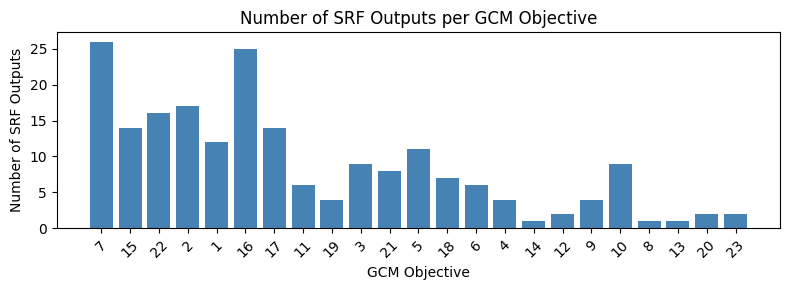

In [ ]:
#| eval: false
import matplotlib.pyplot as plt

gcm_ids = list(eval_data.gcm_srf_lut.keys())
srf_counts = [len(srf_outputs) for srf_outputs in eval_data.gcm_srf_lut.values()]

plt.figure(figsize=(8, 3))
plt.bar(gcm_ids, srf_counts, color='steelblue')
plt.xlabel('GCM Objective')
plt.ylabel('Number of SRF Outputs')
plt.title('Number of SRF Outputs per GCM Objective')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#| exports
def get_filtered_srf_output_ids(
    results: PipelineResults, # PipelineResults
    eval_data: EvalData # EvalData
    ) -> list: # list of SRF output IDs
    "Get filtered SRF output IDs based on covered GCM themes."
    covered_gcm = results(Stage.STAGE2, filter_type="tagged")
    srf_output_ids = set()
    
    for gcm_theme in covered_gcm:
        gcm_id = gcm_theme.framework_theme_id
        if gcm_id in eval_data.gcm_srf_lut:
            srf_output_ids.update(eval_data.gcm_srf_lut[gcm_id])
    
    return list(srf_output_ids)

NameError: name 'PipelineResults' is not defined

For instance:

In [ ]:
#| eval: false
filtered_srfs = get_filtered_srf_output_ids(orchestrator.results, eval_data)

print(f'nb. of filtered srf outputs: {len(filtered_srfs)}')
print(f'first 5: {filtered_srfs[:5]}')

NameError: name 'get_filtered_srf_output_ids' is not defined

In [ ]:
#| exports
@patch
def get_combined_context(self:PipelineOrchestrator) -> str:
    "Get combined context from Stage 1 and Stage 2 tagged themes"
    stage1_context = self.get_stage1_context()
    tagged_gcm = self.results(Stage.STAGE2, filter_type="tagged")
    
    if not tagged_gcm:
        return stage1_context
    
    gcm_context = "\n".join([
        f"- **GCM {theme.framework_theme_id}**: {self.eval_data.gcm_objectives_small[int(theme.framework_theme_id)-1]['title']}" 
        for theme in tagged_gcm
    ])
    
    return f"{stage1_context}\n\n### Covered GCM Objectives\n{gcm_context}"

For instance:

In [ ]:
#| eval: false
print(orchestrator.get_combined_context())

### Report Preliminary Context
This evaluation report covers the following Strategic Results Framework themes:
- **Enablers 2**: Partnership
- **Enablers 4**: Data and evidence
- **Enablers 5**: Learning and Innovation
- **Crosscutting Priorities 3**: Protection-centred

### Covered GCM Objectives
- **GCM 1**: Collect and utilize accurate and disaggregated data as a basis for evidence-based policies
- **GCM 7**: Address and reduce vulnerabilities in migration
- **GCM 12**: Strengthen certainty and predictability in migration procedures for appropriate screening, assessment
and referral
- **GCM 16**: Empower migrants and societies to realize full inclusion and social cohesion
- **GCM 21**: Cooperate in facilitating safe and dignified return and readmission, as well as sustainable 
reintegration
- **GCM 23**: Strengthen international cooperation and global partnerships for safe, orderly and regular migration

In [ ]:
#| exports
@patch
def get_filtered_srf_outputs(self:PipelineOrchestrator) -> list:
    "Get filtered SRF output IDs based on tagged GCM themes"
    tagged_gcm = self.results(Stage.STAGE2, filter_type="tagged")
    srf_output_ids = set()
    
    for gcm_theme in tagged_gcm:
        gcm_id = gcm_theme.framework_theme_id
        if gcm_id in self.eval_data.gcm_srf_lut:
            srf_output_ids.update(self.eval_data.gcm_srf_lut[gcm_id])
    
    return list(srf_output_ids)

In [ ]:
#| eval: false
orchestrator.get_filtered_srf_outputs()[:5]

['1a11', '2c11', '1a16', '3c13', '3c43']

In [ ]:
#| exports
@patch
async def run_stage3(self:PipelineOrchestrator, semaphore):
    "Run stage 3 - Targeted SRF outputs analysis with combined context"
    combined_context = self.get_combined_context()
    filtered_output_ids = self.get_filtered_srf_outputs()
    themes = []
    
    for output_id in filtered_output_ids:
        output_context = find_srf_output_by_id(self.eval_data, output_id)
        if output_context:
            framework_info = FrameworkInfo(Framework.SRF, FrameworkCat.OUTPUTS, output_id)
            theme = format_srf_output(output_context) + "\n\n" + combined_context
            themes.append((theme, framework_info))
    
    log_fn = lambda result, finfo: log_analysis_event(
        "theme_tagged",
        self.report_id,
        stage=Stage.STAGE3,
        framework_info=finfo,
        is_core=result.is_core,
        reasoning=result.reasoning,
        confidence=result.confidence
    )

    results = await self.process_themes_batch(
        themes=themes,
        semaphore=semaphore,
        stage=Stage.STAGE3,
        force_refresh=self.cfg_p.force_refresh.stage3,
        log_fn=log_fn
    )
    
    for result in results: 
        self.results[Stage.STAGE3][result.framework_name][result.framework_category][result.framework_theme_id] = result


In [ ]:
#| eval: false
await orchestrator.run_stage3(semaphore)

49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/1a11
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/1a16
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/2c11
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3c43
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3c13
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/1c21
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3c42
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/1a21
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/1a17
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3c31
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3d35
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3d44
49d2fba781b6a7c0d94577479636ee6f - stage3 - theme_tagged - SRF/Outputs/3c21
49d2fba781b6

In [ ]:
#| eval: false
n_outputs = len(orchestrator.results(Stage.STAGE3, filter_type="tagged"))
print(f"Number of outputs: {n_outputs}")

Number of outputs: 40

## CLI

In [ ]:
#| export
def find_enriched_path(eval_id: str, md_dir: str):
    "Find the enriched markdown directory for an evaluation"
    eval_path = Path(md_dir) / eval_id
    if not eval_path.exists():
        raise FileNotFoundError(f"Evaluation directory not found: {eval_path}")
    
    report_dirs = eval_path.ls().filter(lambda d: d.is_dir() and d.name != 'enriched')
    if not report_dirs:
        raise FileNotFoundError(f"No report directory found in {eval_path}")
    
    doc_path = report_dirs[0] / 'enriched'
    if not doc_path.exists():
        raise FileNotFoundError(f"Enriched directory not found: {doc_path}")
    
    return doc_path

In [ ]:
#| export
def parse_force_refresh(force_refresh_str: str, working_cfg):
    "Parse and apply force_refresh parameter to config"
    if force_refresh_str:
        refresh_items = [s.strip() for s in force_refresh_str.split(',')]
        for item in refresh_items:
            if item == 'sections':
                working_cfg.pipeline.force_refresh.sections = True
            elif item in ['stage1', 'stage2', 'stage3']:
                working_cfg.pipeline.force_refresh[item] = True

In [ ]:
#| export
async def run_selected_stages(orchestrator, semaphore, stages_to_run):
    "Run only the selected pipeline stages"
    await orchestrator.identify_sections(semaphore)
    if 1 in stages_to_run:
        await orchestrator.run_stage1(semaphore)
    if 2 in stages_to_run:
        await orchestrator.run_stage2(semaphore)
    if 3 in stages_to_run:
        await orchestrator.run_stage3(semaphore)

In [ ]:
#| export
@call_parse
def tag_evaluation(
    eval_id: str,  # Evaluation ID to process
    md_dir: str = "_data/md_library",  # Markdown directory
    stages: str = "1,2,3",  # Stages to run (comma-separated: 1,2,3)
    force_refresh: str = None  # Force refresh stages (comma-separated: sections,stage1,stage2,stage3)
):
    "Tag evaluation report against frameworks"
    # Use module's default config
    working_cfg = deepcopy(cfg)
    
    # Find enriched markdown path
    try:
        doc_path = find_enriched_path(eval_id, md_dir)
    except FileNotFoundError as e:
        logging.error(str(e))
        return
    
    # Load report and create heading structure
    report = load_report(doc_path)
    hdgs = create_heading_dict(report)
    
    # Parse parameters
    stages_to_run = [int(s.strip()) for s in stages.split(',')]
    parse_force_refresh(force_refresh, working_cfg)
    
    # Run pipeline
    orchestrator = PipelineOrchestrator(
        report_id=eval_id,
        hdgs=hdgs,
        eval_data=IOMEvalData(),
        cfg=working_cfg
    )
    
    semaphore = Semaphore(working_cfg.semaphore)
    asyncio.run(run_selected_stages(orchestrator, semaphore, stages_to_run))
    
    logging.info(f"Completed tagging for {eval_id}")